In [27]:
import datetime

from flair.data import Sentence
import flair
from flair.models import TextClassifier
from flair.nn import Classifier
from utils import read_transcripts_lines, read_dataset
from dataclasses import dataclass
from model import DataSource
from typing import *
import itertools
from tqdm import tqdm
import csv

@dataclass
class SentimentScoreItem:
    score: float
    date: datetime.date
    positive: bool
    
    
@dataclass
class SentimentScore:
    average_score: float
    date: datetime.date
    
    def __repr__(self):
        return f"date {self.date} has average score {self.average_score}"
    
    def __str__(self):
        return repr(self)
    
    @staticmethod
    def from_items(items: List[SentimentScoreItem]):
        return SentimentScore(sum([item.score if item.positive else -item.score for item in items]) / len(items), items[0].date)


classifier = Classifier.load('sentiment')

def process_datasets(data: List[DataSource], category: str):
    items = []
    for item in tqdm(data):
        sentence = Sentence(item.text)
        classifier.predict(sentence)
        if (len(sentence.labels) > 0):
            items.append(SentimentScoreItem(sentence.labels[0].score, item.date, sentence.labels[0].value == "POSITIVE"))
    print(f"Collected {len(items)} items")
    scores = []
    for (date, items) in itertools.groupby(items, lambda item: item.date):
        scores.append(SentimentScore.from_items(list(items)))
    sorted_scores = sorted(scores, key=lambda item: item.date, reverse=False)
    with open(f"sentiment-scores-{category}.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='"')
        for score in sorted_scores:
            writer.writerow([str(score.date), str(score.average_score)])



scientific_datasets = read_dataset("sentences-annotated-scientific-before.csv") + read_dataset("sentences-annotated-scientific-after.csv")
non_scientific_datasets = read_dataset("sentences-annotated-non-scientific-before.csv") + read_dataset("sentences-annotated-non-scientific-after.csv")

process_datasets(scientific_datasets, "scientific")
process_datasets(non_scientific_datasets, "non-scientific")

print("done")




100%|██████████| 15956/15956 [07:07<00:00, 37.33it/s]


Collected 15956 items


100%|██████████| 2601/2601 [01:22<00:00, 31.71it/s]

Collected 2601 items
done


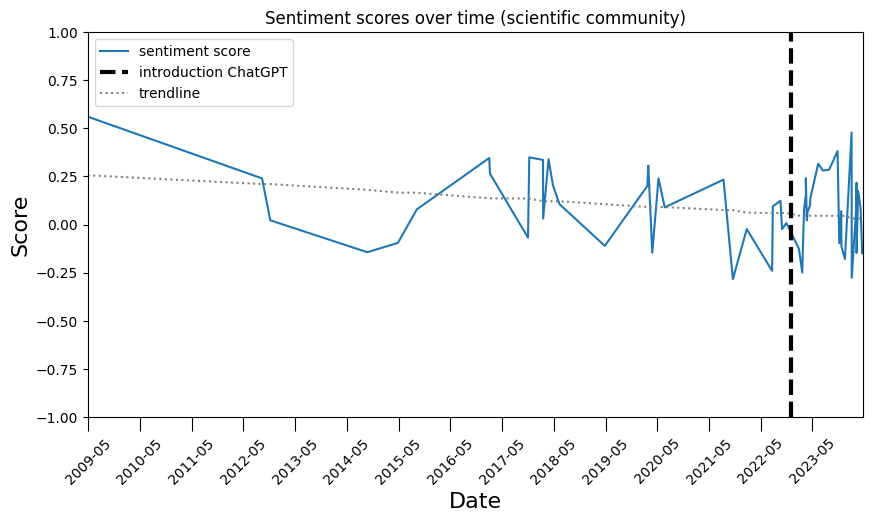

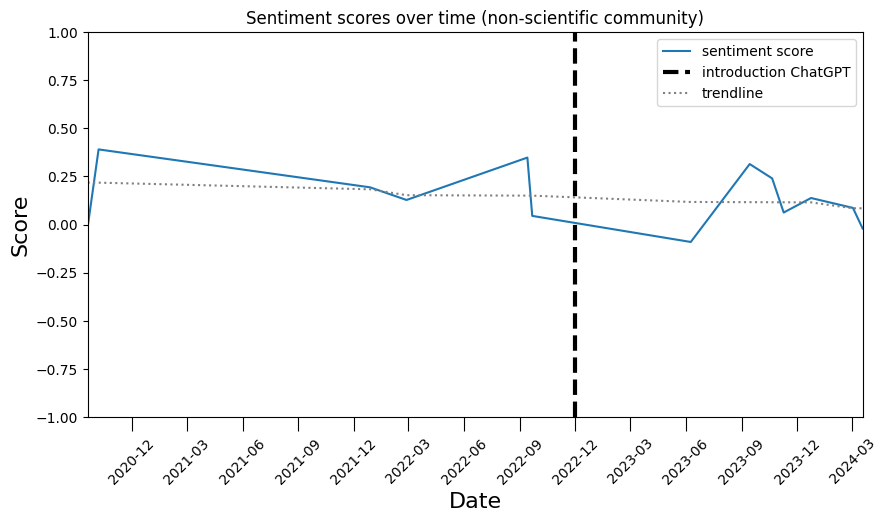

done


In [67]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import sys
import numpy as np


def to_int(date: datetime.date):
    return int(date.strftime("%Y%m%d"))

def plot_sentiment(category: str, month_locator_interval = 12):
    with (open(f"sentiment-scores-{category}.csv", "r") as f):
        csv.field_size_limit(sys.maxsize)
        csvFile = csv.reader(f, delimiter=',', quotechar='"')
        scores = [SentimentScore(float(line[1]), datetime.datetime.strptime(line[0], "%Y-%m-%d").date()) for line in csvFile]
        dates = [score.date for score in scores]
        scores = [score.average_score for score in scores]
        introduction_chatgpt = datetime.date(2022, 11, 30)
        z = np.polyfit([to_int(date) for date in dates], scores, 1)
        p = np.poly1d(z)
        
        fig, ax = plt.subplots(figsize=(10, 5))
        plt.plot(dates, scores, label="sentiment score")
        plt.plot([introduction_chatgpt] * 5, [-1.0, -0.5, 0, 0.5, 1.0], 'k--', label="introduction ChatGPT", linewidth=3)
        plt.plot(dates, p([to_int(date) for date in dates]), ':', color="grey", label="trendline")
        plt.legend()
        ax.set_title(f"Sentiment scores over time ({category} community)")
        ax.xaxis.set_major_locator(md.MonthLocator(interval = month_locator_interval))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)
        ax.tick_params(axis = 'x', which = 'major', length = 10)
        ax.set_xlim(dates[0], dates[-1])
        ax.set_ylim([-1.0, 1.0])
        ax.set_xlabel(f"Date", fontsize=16)
        ax.set_ylabel(f"Score", fontsize=16)
        plt.show()
        fig.savefig(f"sentiment-{category}.png")
    
    
plot_sentiment("scientific")
plot_sentiment("non-scientific", 3)

print("done")
